# Walmart Sales Prediction


  **1) Exploratory Analysis and Data Cleaning**  
  **2) Machine Learning**  
  **3) Christmas Adjustment**  
  **4) Submission**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
features = pd.read_csv(r'C:\Users\Punde\Desktop\Data Science\Kaggle\Walmart sales\features.csv')
train = pd.read_csv(r'C:\Users\Punde\Desktop\Data Science\Kaggle\Walmart sales\train.csv')
stores = pd.read_csv(r'C:\Users\Punde\Desktop\Data Science\Kaggle\Walmart sales\stores.csv')
test = pd.read_csv(r'C:\Users\Punde\Desktop\Data Science\Kaggle\Walmart sales\test.csv')

In [3]:
#features.head()
train.head()
#stores.head()
#test.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## Exploratory Analysis and Data Cleaning

In [4]:
feat_store = features.merge(stores, how='inner', on='Store')

In [5]:
feat_store.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

In [6]:
pd.DataFrame({'train' : train.dtypes, 'test' : test.dtypes})

,train,test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [7]:
feat_store.Date = pd.to_datetime(feat_store.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [8]:
feat_store['Week'] = feat_store.Date.dt.week 
feat_store['Year'] = feat_store.Date.dt.year

In [9]:
train_detail = train.merge(feat_store, how = 'inner',
                           on = ['Store','Date','IsHoliday']).sort_values(by = ['Store',
                                                                                'Dept',
                                                                                'Date']).reset_index(drop = True)

In [10]:
test_detail = test.merge(feat_store, how = 'inner',
                        on = ['Store', 'Date', 'IsHoliday']).sort_values(by = ['Store',
                                                                                 'Dept',
                                                                                 'Date']).reset_index(drop = True)

In [11]:
train_detail.shape

(421570, 18)

In [12]:
# checking null entries
null_col = train_detail.isnull().sum().sort_values(ascending = False).index
null_data = pd.concat([train_detail.isnull().sum(),
                      (train_detail.isnull().sum()/len(train_detail)).sort_values(ascending = False),
                      train_detail.loc[:,train_detail.columns.isin(list(null_col))].dtypes], axis = 1)
null_data = null_data.rename(columns = {0 :'# Null', 1 : '% Null', 2 : 'Dtype'}).sort_values(ascending=False, by='# Null')
null_data = null_data[null_data['# Null'] != 0]
null_data

,# Null,% Null,Dtype
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


This is important, there are columns with more than 60% of null values. If the correlations of these features with the target 'WeeklySales' are ~0, then it is not a good idea to use them.

### Holiday Analysis

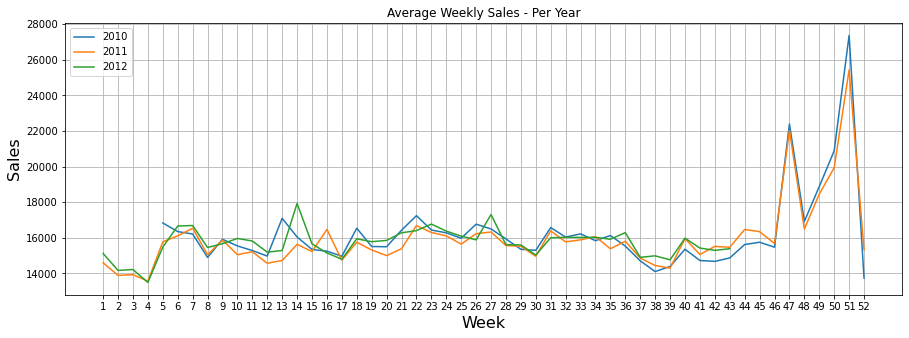

In [13]:
weekly2010 = train_detail[train_detail.Year == 2010]['Weekly_Sales'].groupby(train_detail.Week).mean()
weekly2011 = train_detail[train_detail.Year == 2011]['Weekly_Sales'].groupby(train_detail.Week).mean()
weekly2012 = train_detail[train_detail.Year == 2012]['Weekly_Sales'].groupby(train_detail.Week).mean()

plt.figure(figsize = (15,5))
sns.lineplot(weekly2010.index, weekly2010.values)
sns.lineplot(weekly2011.index, weekly2011.values)
sns.lineplot(weekly2012.index, weekly2012.values)
plt.grid()
plt.legend(['2010', '2011', '2012'], loc='best')
plt.xticks(np.arange(1,53))
plt.title('Average Weekly Sales - Per Year')
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

> As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks. 
    >* In 2010 is in Week 13
    >* In 2011, Week 16
    >* Week 14 in 2012

> So, we can change to 'True' these Weeks in each Year. and Week 13 in 2013 for Test set

In [14]:
train_detail.loc[(train_detail.Year == 2010) & (train_detail.Week == 13),'IsHoliday'] = True
train_detail.loc[(train_detail.Year == 2011) & (train_detail.Week == 16),'IsHoliday'] = True
train_detail.loc[(train_detail.Year == 2012) & (train_detail.Week == 14),'IsHoliday'] = True
test_detail.loc[(test_detail.Year == 2013) & (test_detail.Week == 13),'IsHoliday'] = True

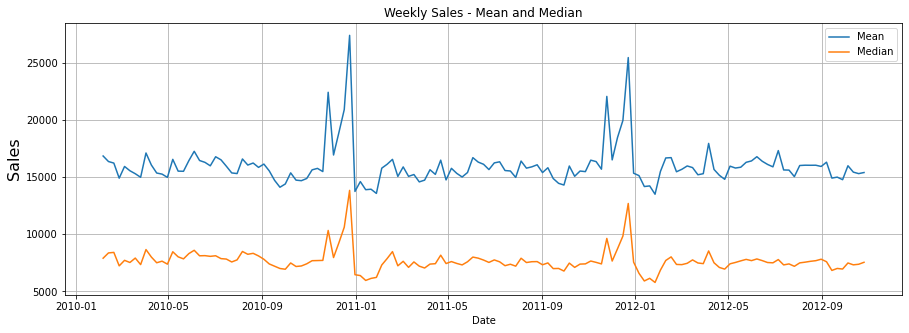

In [15]:
weekly_mean = train_detail.Weekly_Sales.groupby(train_detail.Date).mean()
weekly_median = train_detail.Weekly_Sales.groupby(train_detail.Date).median()
plt.figure(figsize = (15,5))
sns.lineplot(weekly_mean.index, weekly_mean.values)
sns.lineplot(weekly_median.index, weekly_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best')
plt.title('Weekly Sales - Mean and Median')
plt.ylabel('Sales', fontsize=16)
plt.show()

As an observation, the mean and the median are very different, suggesting that some stores/departments might sell much more than others.

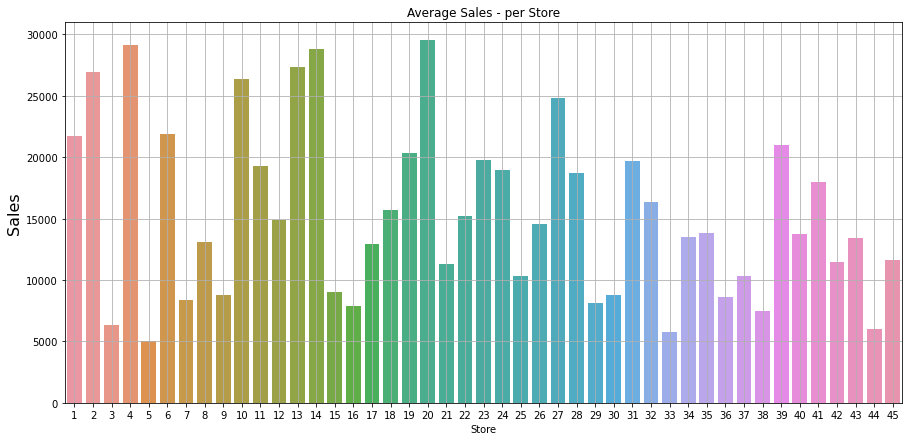

In [16]:
#Average sale per store
weekly_sale = train_detail.Weekly_Sales.groupby(train_detail.Store).mean()
plt.figure(figsize = (15,7))
sns.barplot(weekly_sale.index, weekly_sale.values)
plt.grid()
plt.title('Average Sales - per Store')
plt.ylabel('Sales', fontsize=16)
plt.show()

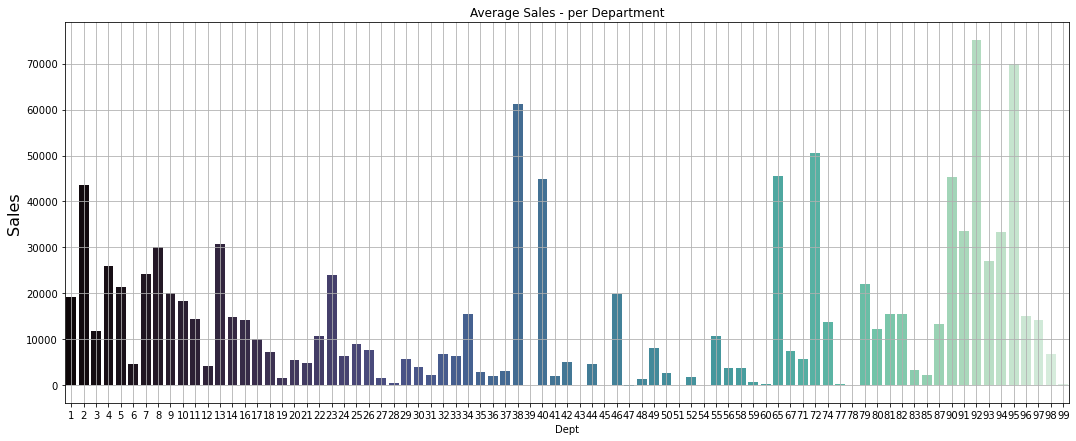

In [17]:
#Average sale per department
weekly_sale = train_detail.Weekly_Sales.groupby(train_detail.Dept).mean()
plt.figure(figsize = (18,7))
sns.barplot(weekly_sale.index, weekly_sale.values, palette = 'mako')
plt.grid()
plt.title('Average Sales - per Department')
plt.ylabel('Sales', fontsize=16)
plt.show()

### Variables Correlation
Let's see the correlation between variables, using Pearson Correlation.

Correlation Metrics:

0: no correlation at all  
0-0.3: weak correlation  
0.3-0.7: moderate correlaton  
0.7-1: strong correlation  
  
Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite

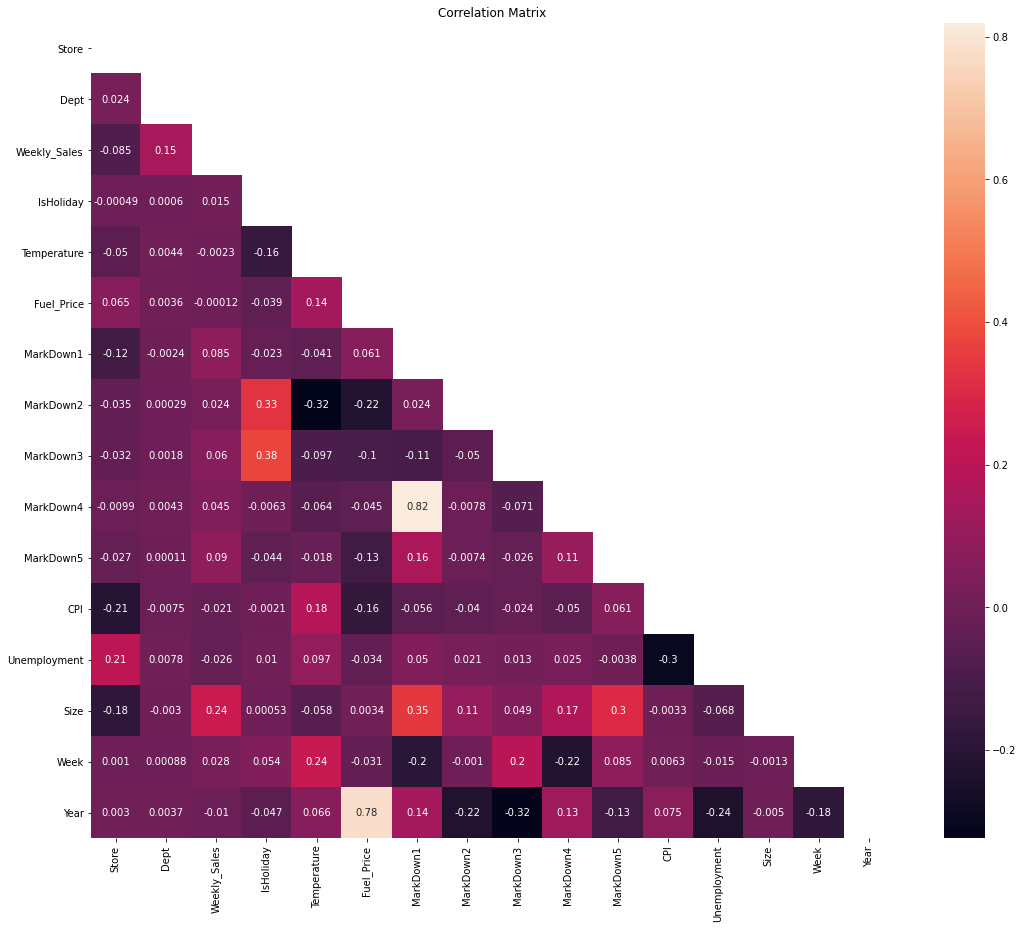

In [18]:
corr = train_detail.corr()
plt.figure(figsize = (18,15))
sns.heatmap(corr, mask = np.triu(np.ones_like(corr, dtype=np.bool)), annot = True)
plt.title('Correlation Matrix')
plt.show()

'MarkDown' 1 to 5 are not strong correlated to 'Weekly_Sales' and they have a lot of null values, then we can drop them.

Also, 'Fuel_Price' is strong correlated to 'Year'. One of them must be dropped else they would carry similar information to the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'.

In [19]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

**Analyzing variables**

The discrete plot is for finite numbers. We will use boxplot, to see the medians and interquartile ranges, and the striplot, which is a better way of seeing the distribution, even more when lots of outliers are present.

In [20]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(15,7))
    gs = GridSpec(1,2)
    
    sns.boxplot(train_detail[feature], train_detail.Weekly_Sales, ax = fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(train_detail[feature], train_detail.Weekly_Sales, ax = fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

C:\Users\Punde\Anaconda3\envs\friday\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


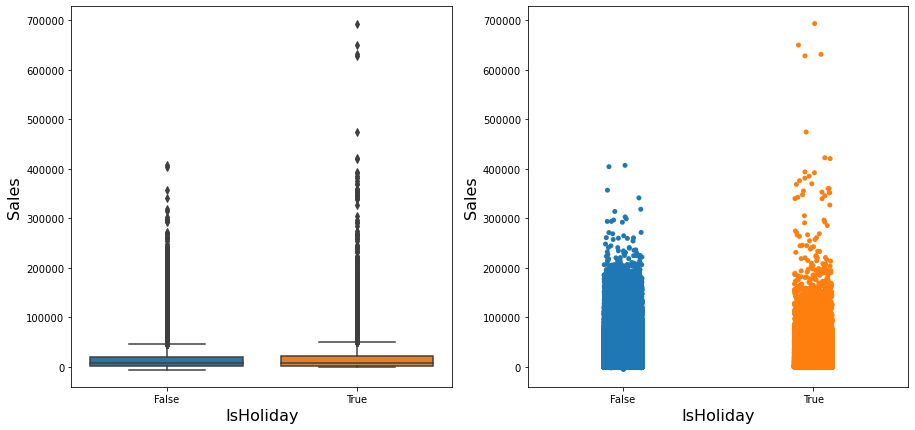

In [21]:
make_discrete_plot('IsHoliday')

This field is going to be important to differentiate Week Holidays. As we can see, Week Holidays have more high sales events than non-Holiday Weeks.

In [22]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
train_detail.IsHoliday = encoder.fit_transform(train_detail.IsHoliday)
test_detail.IsHoliday = encoder.transform(test_detail.IsHoliday)
test_detail.head()

,Store,Dept,Date,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2012-11-02,0,55.32,223.462779,6.573,A,151315,44,2012
1,1,1,2012-11-09,0,61.24,223.481307,6.573,A,151315,45,2012
2,1,1,2012-11-16,0,52.92,223.512911,6.573,A,151315,46,2012
3,1,1,2012-11-23,1,56.23,223.561947,6.573,A,151315,47,2012
4,1,1,2012-11-30,0,52.34,223.610984,6.573,A,151315,48,2012


C:\Users\Punde\Anaconda3\envs\friday\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


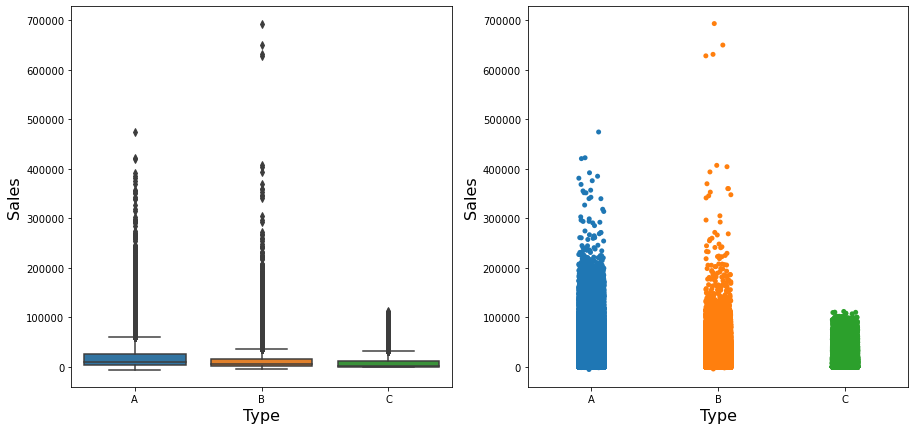

In [23]:
make_discrete_plot('Type')

In [24]:
train_detail = pd.get_dummies(train_detail, columns = ['Type'])
test_detail = pd.get_dummies(test_detail, columns = ['Type'])
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Size,Week,Year,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,42.31,211.096358,8.106,151315,5,2010,1,0,0
1,1,1,2010-02-12,46039.49,1,38.51,211.242170,8.106,151315,6,2010,1,0,0
2,1,1,2010-02-19,41595.55,0,39.93,211.289143,8.106,151315,7,2010,1,0,0
3,1,1,2010-02-26,19403.54,0,46.63,211.319643,8.106,151315,8,2010,1,0,0
4,1,1,2010-03-05,21827.90,0,46.50,211.350143,8.106,151315,9,2010,1,0,0



The continuous plot is for continuous variables. We will see the distribution of probabilities and use BoxCox to understand if there is increase of correlation and decrease of skewness for each variable. In some cases the process of transforming a variable can help, depending on the model.

In [25]:
def make_continuous_plot(feature):
    #Boxcox1p(x, lambda) : ((1+x)**lambda -1) / lambda | if lambda != 0
    #                       log(1+x)                   | if lambda == 0
    
    fig = plt.figure(figsize=(15,5))
    gs = GridSpec(1,3)
    #(0,0)
    sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    #(0,1)
    sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),3)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),3)))

    #(0,2)
    sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[0,2]), color = 'green')

    plt.title('Distribution\n')
    
    fig.show()

C:\Users\Punde\Anaconda3\envs\friday\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


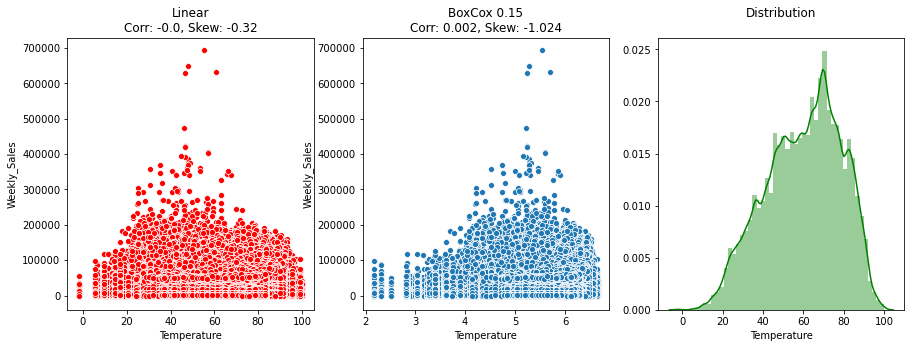

In [26]:
make_continuous_plot('Temperature')

Although skewness changes, correlation doesn't seem to change at all. We can decide to drop temperature.

In [27]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

C:\Users\Punde\Anaconda3\envs\friday\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


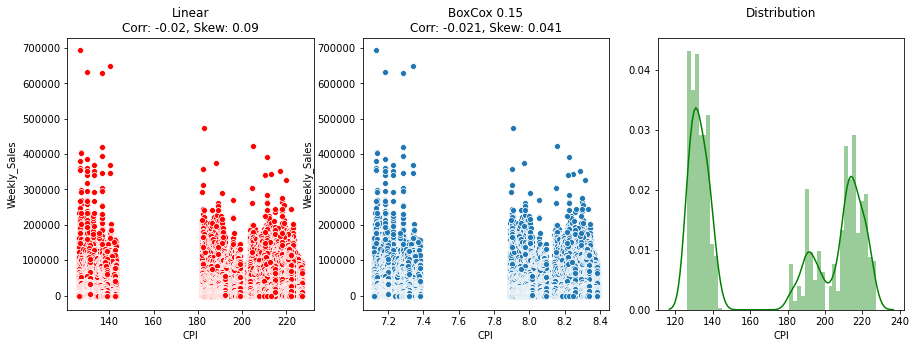

In [28]:
make_continuous_plot('CPI')

In [29]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

C:\Users\Punde\Anaconda3\envs\friday\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


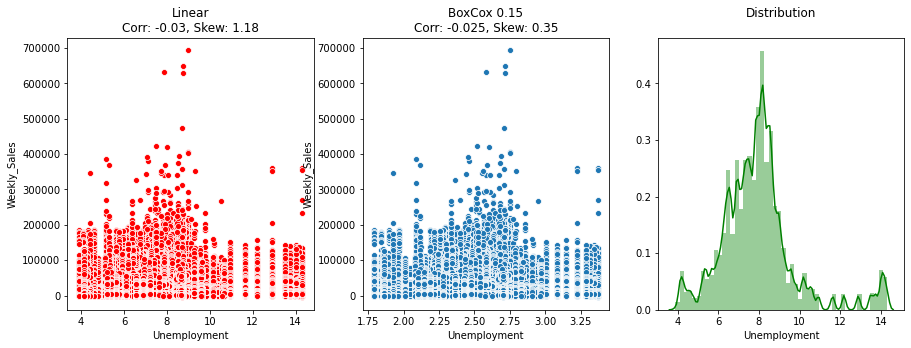

In [30]:
make_continuous_plot('Unemployment')

we will continue with this variable, since it has small correlation with 'WeeklySales'

C:\Users\Punde\Anaconda3\envs\friday\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


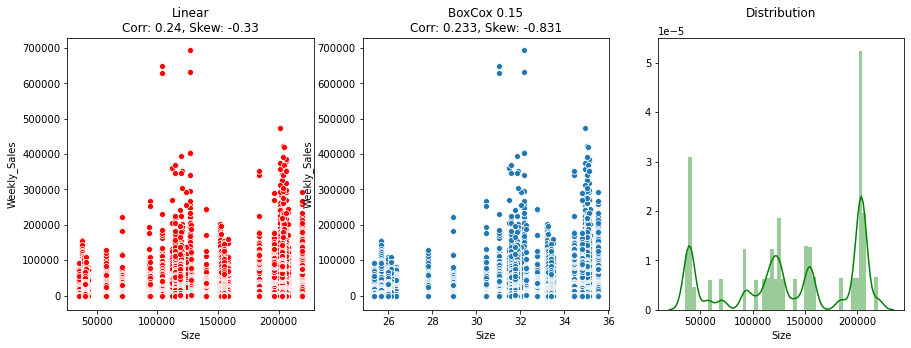

In [31]:
make_continuous_plot('Size')

Finally, we will also continue with size variable, as it has moderate correlation with 'WeeklySales'

## Machine Learning

**Model Functions**  
The evaluation is based on Weighted Mean Absolute Error (WMAE), with a weight of 5 for Holiday Weeks and 1 otherwise.

In [32]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 3)

The model chosen for this project is the Random Forest Regressor(n_estimators, max_depth, max_features). It is an ensemble method and uses multiples decision trees ('n_estimators' parameter of the model) to determine final output, which is an average of the outputs of all trees.

In [33]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [35]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

**Model Training**

In [34]:
print(train_detail.columns, test_detail.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Unemployment',
       'Size', 'Week', 'Year', 'Type_A', 'Type_B', 'Type_C'],
      dtype='object') Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Unemployment', 'Size', 'Week',
       'Year', 'Type_A', 'Type_B', 'Type_C'],
      dtype='object')


In [46]:
X_train = train_detail[['Store', 'Dept', 'IsHoliday', 'Unemployment', 'Size', 'Week', 'Year', 'Type_A', 'Type_B']]
Y_train = train_detail['Weekly_Sales']
X_train.describe()

,Store,Dept,IsHoliday,Unemployment,Size,Week,Year,Type_A,Type_B
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,0.091439,7.960289,136727.915739,25.826762,2010.968591,0.511132,0.387824
std,12.785297,30.492054,0.288233,1.863296,60980.583328,14.151887,0.796876,0.499877,0.487255
min,1.000000,1.000000,0.000000,3.879000,34875.000000,1.000000,2010.000000,0.000000,0.000000
25%,11.000000,18.000000,0.000000,6.891000,93638.000000,14.000000,2010.000000,0.000000,0.000000
50%,22.000000,37.000000,0.000000,7.866000,140167.000000,26.000000,2011.000000,1.000000,0.000000
75%,33.000000,74.000000,0.000000,8.572000,202505.000000,38.000000,2012.000000,1.000000,1.000000
max,45.000000,99.000000,1.000000,14.313000,219622.000000,52.000000,2012.000000,1.000000,1.000000


In [39]:
n_estimators = [50, 55, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 30 , max_depth: 20
k: 2 , n_estimators: 30 , max_depth: 20
k: 3 , n_estimators: 30 , max_depth: 20
k: 4 , n_estimators: 30 , max_depth: 20
WMAE: 1662.5522500000002
k: 1 , n_estimators: 30 , max_depth: 25
k: 2 , n_estimators: 30 , max_depth: 25
k: 3 , n_estimators: 30 , max_depth: 25
k: 4 , n_estimators: 30 , max_depth: 25
WMAE: 1589.2067500000003
k: 1 , n_estimators: 30 , max_depth: 30
k: 2 , n_estimators: 30 , max_depth: 30
k: 3 , n_estimators: 30 , max_depth: 30
k: 4 , n_estimators: 30 , max_depth: 30
WMAE: 1600.7890000000002
k: 1 , n_estimators: 40 , max_depth: 20
k: 2 , n_estimators: 40 , max_depth: 20
k: 3 , n_estimators: 40 , max_depth: 20
k: 4 , n_estimators: 40 , max_depth: 20
WMAE: 1638.46675
k: 1 , n_estimators: 40 , max_depth: 25
k: 2 , n_estimators: 40 , max_depth: 25
k: 3 , n_estimators: 40 , max_depth: 25
k: 4 , n_estimators: 40 , max_depth: 25
WMAE: 1601.9672500000001
k: 1 , n_estimators: 40 , max_depth: 30
k: 2 , n_estimators: 40 , max_depth: 30
k: 

,Max_Depth,Estimators,WMAE
0,20,30,1662.55225
1,25,30,1589.20675
2,30,30,1600.78900
3,20,40,1638.46675
4,25,40,1601.96725
5,30,40,1601.35200
6,20,50,1641.97525
7,25,50,1585.40850
8,30,50,1583.33125


Best estimates with n = 50, depth = 30

In [41]:
max_features = [4, 6, 8]

random_forest_II(n_estimators=50, max_depth=27, max_features=max_features)

k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 2693.57925
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1669.94075
k: 1 , max_features: 8
k: 2 , max_features: 8
k: 3 , max_features: 8
k: 4 , max_features: 8
WMAE: 1594.4195


,Max_Feature,WMAE
0,4,2693.57925
1,6,1669.94075
2,8,1594.41950


max features == 8

In [38]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=8)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=8, n_estimators=58)

### Prediction

In [ ]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Unemployment', 'Size', 'Week', 'Year', 'Type_A', 'Type_B']]
X_test.Unemployment.fillna(X_test.Unemployment.median(), inplace = True)
#X_test.describe()#isnull().sum()#head()
predict = RF.predict(X_test)

C:\Users\Punde\Anaconda3\envs\friday\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
